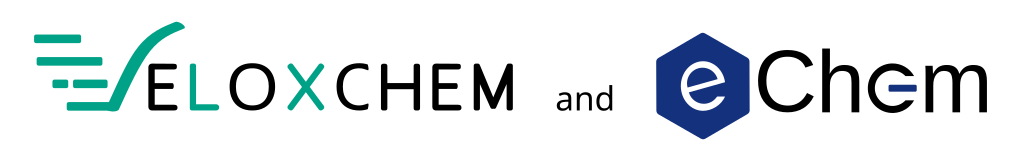

# Analytical Hessian: code prototyping example

In [ ]:
import numpy as np
import veloxchem as vlx
import geometric
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True, precision=10)

The equation for the closed-shell analytical Hessian at the Hartree-Fock (HF) level of theory is
\begin{align}
E^{\chi\xi}\equiv\frac{\mathrm{d}^2 E}{\mathrm{d}\chi\mathrm{d}\xi} &= 2\sum_{\mu \nu} D_{\mu \nu} h_{\mu \nu}^{\xi \chi} + \sum_{\mu \nu \theta \varphi} D_{\mu \nu} D_{\theta \varphi} \left[ 2( \mu \nu | \theta \varphi )^{\xi \chi} - ( \mu \varphi | \theta \nu  )^{\xi \chi} \right] + 2\sum_{\mu \nu} \omega_{\mu \nu} S_{\mu \nu}^{\xi \chi} + \frac{\mathrm{d}^2 V_\mathrm{NN}}{\mathrm{d} \chi \mathrm{d} \xi}\\
  &+ 2\sum_{\mu \nu} \frac{\mathrm{d} D_{\mu \nu}}{\mathrm{d} \chi} h_{\mu \nu}^{\xi} + 2\sum_{\mu \nu \theta \varphi} \frac{\mathrm{d} D_{\mu \nu}}{\mathrm{d} \chi} D_{\theta \varphi} \left[ 2( \mu \nu | \theta \varphi )^{\xi} - ( \mu \varphi | \theta \nu  )^{\xi} \right] + 2\sum_{\mu \nu} \frac{\mathrm{d} \omega_{\mu \nu}}{\mathrm{d} \chi} S_{\mu \nu}^{\xi}  
\end{align} 

Here, $E$ is the HF energy, $\mu$, $\nu$, $\theta$, $\varphi$ denote atomic orbitals, $D_{\mu \nu}$ one-electron density matrix elements in atomic-orbital (AO) basis, $h_{\mu \nu}$ core Hamiltonian matrix elements, $( \mu \nu | \theta \varphi )$ electron-repulsion integrals in chemists' ("1122") notation, $S_{\mu \nu}$ overlap matrix elements, and $\omega_{\mu\nu}$ energy-weighted density matrix elements in AO basis. Furthermore, $V_\mathrm{NN}$ represents the nuclear-nuclear repulsion. The superscripts $\xi$ and $\chi$ mark derivatives with respect to the corresponding nuclear coordinates. The terms containing $\omega_{\mu\nu}$ and derivatives of $D_{\mu\nu}$ account for orbital relaxation and arise because the basis functions are atom-centred. It is possible to calculate a so-called (orbital) *unrelaxed* Hessian by neglecting these terms.

The implementation of the analytical Hessian expression may be checked by comparison with a numerical Hessian. This numerical Hessian can be calculated using just the energy $E$ with displaced nuclear coordinates:
$$
\frac{\mathrm{d}^2 E}{\mathrm{d}\chi\mathrm{d}\xi} \approx \frac{E(\xi + \xi_0, \chi + \chi_0) - E(\xi + \xi_0, \chi) - E(\xi, \chi + \chi_0) + 2 E(\xi, \chi) - E(\xi - \xi_0, \chi) - E(\xi, \chi - \chi_0) + E(\xi - \xi_0, \chi - \chi_0)}{2 \xi_0 \chi_0} 
$$ 

with the diagonal term
$$
\frac{\mathrm{d}^2 E}{\mathrm{d}\xi^2} \approx \frac{E(\xi + \xi_0) - 2 E(\xi) + E(\xi - \xi_0)}{\xi^2_0} 
$$ 


Another option is the calculation based on the analytical gradient:
$$
\frac{\mathrm{d}^2 E}{\mathrm{d}\chi\mathrm{d}\xi} \approx \frac{g_\xi(\chi + \chi_0) - g_\xi(\chi - \chi_0)}{2\chi_0} 
$$ 

Here, $g_\xi = {\mathrm{d} E/\mathrm{d} \xi}$ is the analytical energy derivative with respect to nuclear coordinate $\xi$, while $\xi_0$ and $\chi_0$ represent small displacements of the nuclear coordinates $\xi$ and  $\chi$, respectively. By distoring the molecular geometry and re-calculating the energy or gradient after a self-consistent field (SCF) optimization, the *relaxed* numerical Hessian is obtained. However, if these quantities are calculated using the molecular orbital (MO) coefficients of the undistorded molecule, an *unrelaxed* numerical Hessian may be obtained. This unrelaxed numerical Hessian allows to check if the terms in the analytical Hessian which are not related to orbital relaxation have been implemented correctly.

## S1. The unrelaxed analytical Hessian
We start by implementing an orbital-unrelaxed version of the analytical Hessian:
\begin{align}
E^{\chi\xi}_\textrm{unrel} &= 2\sum_{\mu \nu} D_{\mu \nu} h_{\mu \nu}^{\xi \chi} + \sum_{\mu \nu \theta \varphi} D_{\mu \nu} D_{\theta \varphi} \left[ 2( \mu \nu | \theta \varphi )^{\xi \chi} - ( \mu \varphi | \theta \nu  )^{\xi \chi} \right] + \frac{\mathrm{d}^2 V_\mathrm{NN}}{\mathrm{d} \chi \mathrm{d} \xi}
\end{align}

For this, the first step is to perform an SCF calculation. We will illustrate this for the ethylene molecule, but you can choose any molecule you like as long as it is not too big.

In [ ]:
molecule = vlx.Molecule.read_smiles("C=C")
basis_set_label = "def2-svp"
basis = vlx.MolecularBasis.read(molecule, basis_set_label, ostream=None)

In [ ]:
molecule.show()

In [ ]:
scf_drv = vlx.ScfRestrictedDriver()
conv_thresh = 1e-9
scf_drv.conv_thresh = conv_thresh
scf_tensors = scf_drv.compute(molecule, basis)

In order to calculate the *unrelaxed* analytical Hessian, we need the density matrix, the second-order integral derivatives, as well as the second-order derivatives of the nuclear-nuclear repulsion term with respect to the nuclear coordinates $\chi$ and $\xi$. This last term is calculated as

\begin{align}
\frac{\mathrm{d}^2 V_\mathrm{NN}}{\mathrm{d}\chi\mathrm{d}\xi} &= \frac{\mathrm{d} }{\mathrm{d}\chi}\left[\frac{\mathrm{d} }{\mathrm{d}\xi} \left( \frac12\sum_{I\neq J}\frac{Z_IZ_J}{R_{IJ}}\right)\right]
\end{align}

where $Z_I$ is the nuclear charge of atom $I$ and $R_{IJ}$ is the interatomic distance between atoms $I$ and $J$,

$$
R_{IJ} = \sqrt{\sum_{\zeta=x,y,z}(\zeta_I - \zeta_J)^2}
$$

The second-order derivative of $V_\mathrm{NN}$ is relatively straightforward to calculate. For this, we will indicate the atom to which coordinates $\xi$ and $\chi$ belong by a subscript $A$, respectively $B$, leading to the following form:
\begin{align}
\frac{\mathrm{d}^2 V_\mathrm{NN}}{\mathrm{d}\chi_B\mathrm{d}\xi_A} &= \frac12 \sum_{I \neq J} \left[ \frac{3Z_IZ_J (\zeta_I - \zeta_J)(\upsilon_I - \upsilon_J)}{R^5_{IJ}}\delta_{IA}\delta_{IB}\delta_{\zeta\xi}\delta_{\upsilon\chi} - \frac{3Z_IZ_J (\zeta_I - \zeta_J)(\upsilon_I - \upsilon_J)}{R^5_{IJ}}\delta_{IA}\delta_{JB}\delta_{\zeta\xi}\delta_{\upsilon\chi} \right.\\
&~~~~~~~~~~~~~~~ -\frac{Z_IZ_J}{R^3_{IJ}}\delta_{IA}\delta_{IB}\delta_{\zeta\xi}\delta_{\upsilon\chi} + \frac{Z_IZ_J}{R^3_{IJ}}\delta_{IA}\delta_{JB}\delta_{\zeta\xi}\delta_{\upsilon\chi} + \frac{Z_IZ_J}{R^3_{IJ}}\delta_{JA}\delta_{IB}\delta_{\zeta\xi}\delta_{\upsilon\chi} - \frac{Z_IZ_J}{R^3_{IJ}}\delta_{JA}\delta_{JB}\delta_{\zeta\xi}\delta_{\upsilon\chi} \\
&~~~~~~~~~~~~~~~ \left. -\frac{3Z_IZ_J (\zeta_I - \zeta_J)(\upsilon_I - \upsilon_J)}{R^5_{IJ}}\delta_{JA}\delta_{IB}\delta_{\zeta\xi}\delta_{\upsilon\chi} + \frac{3Z_IZ_J (\zeta_I - \zeta_J)(\upsilon_I - \upsilon_J)}{R^5_{IJ}}\delta_{JA}\delta_{JB}\delta_{\zeta\xi}\delta_{\upsilon\chi} \right]
\end{align}

A straightforward implementation of this equation is given below.

In [ ]:
def calculate_nuclear_repulsion_second_derivative(molecule):
    """Implements the second derivative of the nuclear-nuclear repulsion term with
    respect to the nuclear coordinates.

    :param molecule: the VeloxChem molecule object.
    """
    natm = molecule.number_of_atoms()
    nuc_contrib = np.zeros((natm, natm, 3, 3))

    # atom coordinates (n x 3)
    coords = molecule.get_coordinates_in_bohr()

    # atomic charges
    nuclear_charges = molecule.get_charges()

    # loop over all distinct atom pairs and add energy contribution
    for i in range(natm):
        z_a = nuclear_charges[i]
        r_a = coords[i]
        # upper triangular part
        for j in range(natm):
            if i != j:
                z_b = nuclear_charges[j]
                r_b = coords[j]
                r = np.sqrt(np.dot(r_a - r_b, r_a - r_b))
                for k in range(3):
                    for l in range(3):
                        # off-diagonal parts
                        nuc_contrib[i, j, k, l] = (
                            -3
                            * z_a
                            * z_b
                            * (r_b[k] - r_a[k])
                            * (r_b[l] - r_a[l])
                            / r**5
                        )
                        if k == l:
                            nuc_contrib[i, j, k, l] += z_a * z_b / r**3

                        # add the diagonal contribution
                        nuc_contrib[i, i, k, l] += (
                            3 * z_a * z_b * (r_b[k] - r_a[k]) * (r_b[l] - r_a[l]) / r**5
                        )
                        if k == l:
                            nuc_contrib[i, i, k, l] -= z_a * z_b / r**3

    return nuc_contrib

In [ ]:
# The density matrix in AO basis (D_mu,nu):
density_matrix = scf_tensors["D_alpha"]

# The nuclear-nuclear repulsion second derivative:
nuclear_repulsion_term = calculate_nuclear_repulsion_second_derivative(molecule)

To get the second derivative of the core Hamiltonian with respect to the nuclear coordinates, we must determine the kinetic energy, $(\mu|\nabla^2|\nu)$, and nuclear attraction, $\left(\mu\right|\sum_I {Z_I}/{|\mathbf{r} - \mathbf{R}_I|}\left|\nu\right)$, second derivatives. We will create a routine which sums these up to obtain the core Hamiltonian second derivative.
$$
h_{\mu\nu}^{\xi\chi}= \frac{\mathrm{d}^2 }{\mathrm{d}\chi_B\mathrm{d}\xi_A}\left[(\mu|\nabla^2|\nu) - \left(\mu\right|\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}\left|\nu\right)\right]
$$
Here we note that only the derivatives of the AO orbitals are required for the kinetic energy term, but both the derivatives of the orbitals, as well as the operator are involved in the case of the nuclear attraction term, since the operator depends on the position vectors of the nuclei, $\mathbf{R}_I$.
\begin{align}
h_{\mu\nu}^{\xi\chi} &= (\mu^{\xi\chi}|\nabla^2|\nu) + (\mu^{\xi}|\nabla^2|\nu^{\chi}) + (\mu^{\chi}|\nabla^2|\nu^{\xi}) + (\mu|\nabla^2|\nu^{\xi\chi}) \\
&-\left[ (\mu^{\xi\chi} |\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}|\nu) + \left(\mu^\xi\right|\left(\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}\right)^\chi|\nu) +  (\mu^{\xi} |\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}|\nu^\chi) \right] \\
&-\left[ \left(\mu^\chi\right|\left(\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}\right)^\xi|\nu) + \left(\mu\right|\left(\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}\right)^{\xi\chi}|\nu) + \left(\mu\right|\left(\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}\right)^\xi|\nu^\chi)\right] \\
&-\left[ (\mu^{\chi} |\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}|\nu^\xi) + \left(\mu\right|\left(\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}\right)^\chi|\nu^\xi) +  (\mu |\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}|\nu^{\xi\chi}) \right]
\end{align}

We can identify integrals derivatives of different types, which we will denote in the code in the following way:
- **101**: derivatives of the bra and ket orbitals, e.g. $(\mu^{\xi}|\nabla^2|\nu^{\chi})$,
- **200**: second derivatives on just one of the orbital, e.g.  $(\mu^{\xi\chi}|\nabla^2|\nu)$,
- **110**: derivatives of one orbital and the operator, e.g.  $(\mu^{\xi}|\left(\sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|}\right)^\chi|\nu)$,
- **020**: second derivatives of the operator. 

In the case of the kinetic energy integrals, the operator does not depend on the nuclear coordinates, so the integral derivatives of **110** and **020** type are zero and need not be considered.

With these four types of integrals, we can now build the second order derivatives of the core Hamiltonian.

In [ ]:
def hcore_second_derivative(molecule, basis, i, j):
    """Determines the second derivative of the core Hamiltonian
    with respect to the xyz-coordinates of atoms i and j.

    :param molecule: the molecule.
    :param basis: the basis set.
    :param i: the index of the first atom.
    :param j: the index of the second atom.
    """
    nao = basis.get_dimension_of_basis()

    # For a pair of atoms (i, j) the core Hamiltonian derivative
    # has the shape of 3 x 3 x nao x nao
    hcore_deriv = np.zeros((3, 3, nao, nao))

    # We need the kinetic energy and nuclear attraction potential energy derivatives
    kin_hess_101_drv = vlx.KineticEnergyGeom101Driver()
    npot_hess_110_drv = vlx.NuclearPotentialGeom110Driver()
    npot_hess_101_drv = vlx.NuclearPotentialGeom101Driver()

    kin_hess_101 = kin_hess_101_drv.compute(molecule, basis, i, j)
    npot_hess_110_ij = npot_hess_110_drv.compute(molecule, basis, i, j)
    npot_hess_110_ji = npot_hess_110_drv.compute(molecule, basis, j, i)
    npot_hess_101 = npot_hess_101_drv.compute(molecule, basis, i, j)

    # extract the derivatives as numpy arrays
    for x, label_x in enumerate("XYZ"):
        for y, label_y in enumerate("XYZ"):
            label = label_x + "_" + label_y
            kin_hess_101_xy = kin_hess_101.matrix_to_numpy(label)
            # for npot_hess_110 we need the derivative of the orbital wrt. x and operator wrt. y
            # as well as the derivative of the orbital wrt. y and operator wrt. x
            npot_hess_110_xy = npot_hess_110_ij.matrix_to_numpy(
                label_x + "_" + label_y
            ) + npot_hess_110_ji.matrix_to_numpy(label_y + "_" + label_x)
            npot_hess_101_xy = npot_hess_101.matrix_to_numpy(label)
            hcore_deriv[x, y] += (
                kin_hess_101_xy
                + kin_hess_101_xy.T  # (mu^x | nabla^2| nu^y) + (mu^y | nabla^2 | nu^x)
                - (npot_hess_110_xy + npot_hess_110_xy.T)
                - (npot_hess_101_xy + npot_hess_101_xy.T)
            )
    if i == j:
        kin_hess_200_drv = vlx.KineticEnergyGeom200Driver()
        npot_hess_200_drv = vlx.NuclearPotentialGeom200Driver()
        # TODO: import NuclerPotentialGeom020Driver in __init__; ask Xin to fix in master
        npot_hess_020_drv = vlx.veloxchemlib.NuclearPotentialGeom020Driver()
        kin_hess_200 = kin_hess_200_drv.compute(molecule, basis, i)
        npot_hess_200 = npot_hess_200_drv.compute(molecule, basis, i)
        npot_hess_020 = npot_hess_020_drv.compute(molecule, basis, i)

        # extract the derivatives as numpy arrays
        for x, label_x in enumerate("XYZ"):
            for y, label_y in enumerate("XYZ"):
                label = label_x + label_y if x <= y else label_y + label_x
                kin_hess_200_xy = kin_hess_200.matrix_to_numpy(label)
                npot_hess_200_xy = npot_hess_200.matrix_to_numpy(label)
                npot_hess_020_xy = npot_hess_020.matrix_to_numpy(label)
                hcore_deriv[x, y] += (
                    kin_hess_200_xy
                    + kin_hess_200_xy.T
                    - (npot_hess_200_xy + npot_hess_200_xy.T)
                    - npot_hess_020_xy
                )

    return hcore_deriv

Besides the core Hamiltonian, we also need the second order derivatives of the two-electron repulsion integrals. These will be automatically contracted with one density matrix, to obtain the second derivatives of the Coulomb and exchange matrices.
$$
\sum_{\mu \nu \theta \varphi} D_{\mu \nu} D_{\theta \varphi} \left[ 2( \mu \nu | \theta \varphi )^{\xi \chi} - ( \mu \varphi | \theta \nu  )^{\xi \chi} \right]  = \sum_{\mu \nu} D_{\mu \nu} \left( 2J_{\mu\nu}^{\xi \chi} - K_{\mu\nu}^{\xi \chi}\right)
$$
The routine implemented below will return the $2J_{\mu\nu}^{\xi \chi} - K_{\mu\nu}^{\xi \chi}$ derivatives. 

In [ ]:
def aux_2jk_second_derivative(molecule, basis, density_matrix, i, j):
    """Computes the contribution to the Hessian of the second order
    derivatives of the Fock matrix (2J-K). These are two-electron integrals
    contracted onece with the density matrix.

    :param molecule: the molecule.
    :param basis: the basis set.
    :param density_matrix: the density matrix to be contracted with the
                           integral derivatives twice.
    :param i: the index of the first atom.
    :param j: the index of the second atom.
    """
    nao = basis.get_dimension_of_basis()

    eri_contrib = np.zeros((3, 3, nao, nao))
    fock_hess_2000_drv = vlx.FockGeom2000Driver()
    fock_hess_1100_drv = vlx.FockGeom1100Driver()
    fock_hess_1010_drv = vlx.FockGeom1010Driver()

    den_mat_for_fock = vlx.make_matrix(basis, vlx.mat_t.symmetric)
    den_mat_for_fock.set_values(density_matrix)

    j_1100 = fock_hess_1100_drv.compute(
        basis, molecule, den_mat_for_fock, i, j, "j", 0.0, 0.0
    )
    j_1010 = fock_hess_1010_drv.compute(
        basis, molecule, den_mat_for_fock, i, j, "j", 0.0, 0.0
    )
    k_1100 = fock_hess_1100_drv.compute(
        basis, molecule, den_mat_for_fock, i, j, "k", 0.0, 0.0
    )
    k_1010 = fock_hess_1010_drv.compute(
        basis, molecule, den_mat_for_fock, i, j, "k", 0.0, 0.0
    )

    for x, label_x in enumerate("XYZ"):
        for y, label_y in enumerate("XYZ"):
            label = label_x + "_" + label_y
            eri_contrib[x, y] = (
                2 * j_1100.matrix_to_numpy(label)
                - k_1100.matrix_to_numpy(label)
                + 2 * j_1010.matrix_to_numpy(label)
                - k_1010.matrix_to_numpy(label)
            )

    if i == j:
        j_2000 = fock_hess_2000_drv.compute(
            basis, molecule, den_mat_for_fock, i, "j", 0.0, 0.0
        )
        k_2000 = fock_hess_2000_drv.compute(
            basis, molecule, den_mat_for_fock, i, "k", 0.0, 0.0
        )

        labels = "XYZ"
        for x in range(3):
            for y in range(x, 3):
                label = labels[x] + labels[y]
                eri_contrib[x, y] += 2 * j_2000.matrix_to_numpy(
                    label
                ) - k_2000.matrix_to_numpy(label)
                if x < y:
                    eri_contrib[y, x] += 2 * j_2000.matrix_to_numpy(
                        label
                    ) - k_2000.matrix_to_numpy(label)
    return eri_contrib

The remaining thing to do is to sum the three contributions (core Hamiltonian, electron repulsion integrals and nuclear-nuclear repulsion) and obtain the unrelaxed analytical Hessian
\begin{align}
E^{\xi\chi}_\textrm{unrel} &= 2\sum_{\mu \nu} D_{\mu \nu} h_{\mu \nu}^{\xi \chi} +  \sum_{\mu \nu} D_{\mu \nu} \left( 2J_{\mu\nu}^{\xi \chi} - K_{\mu\nu}^{\xi \chi}\right) + \frac{\mathrm{d}^2 V_\mathrm{NN}}{\mathrm{d} \chi \mathrm{d} \xi}
\end{align}

In [ ]:
# the derivatives of the core Hamiltonian, Coulomb, and exchange matrices with respect to each
# combination of nuclear coordinates have to be contracted with the density matrix to obtain the
# unrelaxed electronic Hessian
natm = molecule.number_of_atoms()
unrelaxed_electronic_hessian = np.zeros((natm, natm, 3, 3))

for i in range(natm):
    for j in range(i, natm):
        # import the core Hamiltonian second derivatives
        hcore_2nd_deriv = hcore_second_derivative(molecule, basis, i, j)
        # import the second derivatives of 2J-K
        aux_2jk_2nd_deriv = aux_2jk_second_derivative(molecule, basis, density_matrix, i, j)
        unrelaxed_electronic_hessian[i, j] += ( 2 * np.einsum("mn, xymn->xy", density_matrix, hcore_2nd_deriv) 
                                                  + np.einsum("mn, xymn->xy", density_matrix, aux_2jk_2nd_deriv))

    # The Hessian is symmetric, so we can use the upper-triangular values to fill in the lower-triangular part.
    for j in range(i):
        unrelaxed_electronic_hessian[i, j] = unrelaxed_electronic_hessian[j, i].T

In [ ]:
# The unrelaxed Hessian is the sum of the unrelaxed electronic Hessian and the nuclear repulsion contribution.
# We reshape it to the usual Hessian shape of ( 3 x natm, 3 x natm)
unrelaxed_hessian = (
    (unrelaxed_electronic_hessian + nuclear_repulsion_term)
    .transpose(0, 2, 1, 3)
    .reshape(natm * 3, natm * 3)
)

In order to check if the *unrelaxed* analytical Hessian is correct, the numerical version has to be implemented. The recipe is to make small distortions and re-calculate the energy, but using the density matrix from the undistorted molecule. We will use the numerical Hessian based on the energy:

$$
 E^{\chi\xi}_\mathrm{unrel} \approx \frac{E(\mathbf{D}^0, \xi + \xi_0, \chi + \chi_0) - E(\mathbf{D}^0,\xi + \xi_0, \chi) - E(\mathbf{D}^0,\xi, \chi + \chi_0) + 2 E(\mathbf{D}^0,\xi, \chi) - E(\mathbf{D}^0,\xi - \xi_0, \chi) - E(\mathbf{D}^0, \xi, \chi - \chi_0) + E(\mathbf{D}^0,\xi - \xi_0, \chi - \chi_0)}{2 \xi_0 \chi_0} 
$$ 

with the diagonal term:
$$
E^{\xi\xi}_\mathrm{unrel} \approx \frac{E(\mathbf{D}^0, \xi + \xi_0) - 2 E(\mathbf{D}^0,\xi) + E(\mathbf{D}^0,\xi - \xi_0)}{\xi^2_0} 
$$

where the variable $\mathbf{D}^0$ is the density matrix of the undistorted molecule (i.e., the unperturbed density). The energy is calculated for the distorted molecular geometry, but using the unperturbed density:

$$
E(\mathbf{D}^0) = 2\sum_{\mu\nu}D^0_{\mu\nu}h_{\mu\nu} + \sum_{\mu\nu\theta\varphi} D^0_{\mu\nu}
    D^0_{\theta\varphi}\left[ 2(\mu\nu|(\theta\varphi) -  (\mu\varphi|\theta\nu)\right] + V_\mathrm{NN}
$$

In [ ]:
def calculate_electronic_energy(molecule, basis, density_matrix):
    """Calculate the electronic energy for a given density matrix.

    :param molecule      : the VeloxChem Molecule object,
    :param basis         : the VeloxChem Basis set object.
    :param density_matrix: the density matrix (numpy array).
    """

    # one-electron Hamiltonian
    T = vlx.compute_kinetic_energy_integrals(molecule, basis)
    V = vlx.compute_nuclear_potential_integrals(molecule, basis)
    hcore = T + V

    # two-electron Hamiltonian
    fock_drv = vlx.FockDriver()
    eri = fock_drv.compute_eri(molecule, basis)

    electronic_energy = (
          2 * np.einsum("mn,mn->", hcore, density_matrix)
        + 2 * np.einsum("mn,tp,mntp->", density_matrix, density_matrix, eri)
            - np.einsum("mn,tp,mptn->", density_matrix, density_matrix, eri)
    )
    return electronic_energy

In [ ]:
def calculate_unrelaxed_numerical_hessian(molecule, basis, conv_thresh, delta_h=0.001):
    """Calculates the orbital-unrelaxed numerical Hessian based on the energy.

    :param molecule   : The VeloxChem Molecule object.
    :param basis      : The VeloxChem Basis set object.
    :param conv_thresh: The SCF convergence threshold.
    :param delta_h    : The step size for molecular distortions (in Bohr).
    """

    # calculate the unperturbed density
    local_scf_drv = vlx.ScfRestrictedDriver()
    local_scf_drv.ostream.mute()
    local_scf_drv.conv_thresh = conv_thresh
    local_scf_tensors = local_scf_drv.compute(molecule, basis)

    # save the unperturbed density matrix
    D0 = local_scf_tensors["D_alpha"]

    energy_0 = ( molecule.nuclear_repulsion_energy()
               + calculate_electronic_energy(molecule, basis, D0)
               )

    # atom labels
    labels = molecule.get_labels()

    # number of atoms
    natm = molecule.number_of_atoms()

    # atom coordinates (n x 3)
    coords = molecule.get_coordinates_in_bohr()

    # unrelaxed numerical hessian
    unrel_num_hessian = np.zeros((natm, 3, natm, 3))

    for i in range(natm):
        for x in range(3):
            # Plus x
            coords[i, x] += delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")

            # calculate the energy for the new,
            # distorted molecule, but with the original,
            # unperturbed density matrix D_0
            nuclear_repulsion_energy = new_mol.nuclear_repulsion_energy()
            electronic_energy = calculate_electronic_energy(new_mol, basis, D0)

            energy_ixp = nuclear_repulsion_energy + electronic_energy

            # Minus x
            coords[i, x] -= 2.0 * delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")

            nuclear_repulsion_energy = new_mol.nuclear_repulsion_energy()
            electronic_energy = calculate_electronic_energy(new_mol, basis, D0)

            energy_ixm = nuclear_repulsion_energy + electronic_energy

            # diagonal terms
            unrel_num_hessian[i, x, i, x] = (
                energy_ixp - 2 * energy_0 + energy_ixm
            ) / delta_h**2

            # return to original geometry
            coords[i, x] += delta_h

            for j in range(i, natm):
                for y in range(3):
                    if (j == i and x != y) or (j != i):
                        # Plus y
                        coords[j, y] += delta_h
                        new_mol = vlx.Molecule(labels, coords, units="au")

                        nuclear_repulsion_energy = new_mol.nuclear_repulsion_energy()
                        electronic_energy = calculate_electronic_energy(
                            new_mol, basis, D0
                        )

                        energy_jyp = nuclear_repulsion_energy + electronic_energy

                        # Plus x, plus y
                        coords[i, x] += delta_h
                        new_mol = vlx.Molecule(labels, coords, units="au")

                        nuclear_repulsion_energy = new_mol.nuclear_repulsion_energy()
                        electronic_energy = calculate_electronic_energy(
                            new_mol, basis, D0
                        )

                        energy_ixp_jyp = nuclear_repulsion_energy + electronic_energy

                        # return x to original
                        coords[i, x] -= delta_h

                        # Minus y
                        coords[j, y] -= 2.0 * delta_h
                        new_mol = vlx.Molecule(labels, coords, units="au")

                        nuclear_repulsion_energy = new_mol.nuclear_repulsion_energy()
                        electronic_energy = calculate_electronic_energy(
                            new_mol, basis, D0
                        )

                        energy_jym = nuclear_repulsion_energy + electronic_energy

                        # Minus x, minus y:
                        coords[i, x] -= delta_h
                        new_mol = vlx.Molecule(labels, coords, units="au")

                        nuclear_repulsion_energy = new_mol.nuclear_repulsion_energy()
                        electronic_energy = calculate_electronic_energy(
                            new_mol, basis, D0
                        )

                        energy_ixm_jym = nuclear_repulsion_energy + electronic_energy

                        # return to original geometry
                        coords[i, x] += delta_h
                        coords[j, y] += delta_h

                        # off-diagonal terms
                        unrel_num_hessian[i, x, j, y] = (
                            energy_ixp_jyp
                            - energy_ixp
                            - energy_jyp
                            + 2 * energy_0
                            - energy_ixm
                            - energy_jym
                            + energy_ixm_jym
                        ) / (2 * delta_h**2)
                        unrel_num_hessian[j, y, i, x] = unrel_num_hessian[i, x, j, y]

    local_scf_drv.ostream.unmute()

    # return reshaped Hessian
    return unrel_num_hessian.reshape(3 * natm, 3 * natm)

In [ ]:
unrelaxed_numerical_hessian = calculate_unrelaxed_numerical_hessian(molecule, basis,
                                                                    conv_thresh)

In [ ]:
atol = 1e-6

if np.max(np.abs(unrelaxed_numerical_hessian - unrelaxed_hessian)) <= atol:
    print(
        "The absolute maximum difference is %.2e, below the tolerance %.2e!\n\nThe unrelaxed Hessian is correct!"
        % (np.max(np.abs(unrelaxed_numerical_hessian - unrelaxed_hessian)), atol)
    )
else:
    print(
        "The absolute maximum difference is %.2e, larger than the tolerance %.2e!\n\nThe unrelaxed Hessian is NOT correct."
        % (np.max(np.abs(unrelaxed_numerical_hessian - unrelaxed_hessian)), atol)
    )

## S2. The partially-relaxed analytical Hessian

After having verified that the unrelaxed Hessian is implemented correctly, we can identify the next term which can be implemented and tested separately. This is the term involving the orbital response Lagrange multipliers $\boldsymbol{\omega}$ and the second order derivatives of the overlap matrix elements. This term originates from taking the derivative of the orbital-response contribution to the analytical HF gradient, but neglecting the orbital response in the Hessian. We therefore refer to the Hessian obtained this way as *partially-relaxed*.

To the unrelaxed expression, we add the contribution from HF orbital-response Lagrange multipliers, $\omega_{\mu\nu}$ and obtain the *partially relaxed* analytical Hessian
\begin{align}
E^{\chi\xi}_\textrm{prel} &= E^{\chi\xi}_\textrm{unrel} + 2\sum_{\mu \nu} \omega_{\mu \nu} S_{\mu \nu}^{\xi \chi}
\end{align}

The first step is to determine the $\boldsymbol\omega$ Lagrange multipliers, or energy-weighted density matrix, given in terms of HF orbital energies $\varepsilon_i$ and MO coefficients $C_{\mu i}$ as
$$
\omega_{\mu\nu} = -\sum_i\varepsilon_iC_{\mu i } C_{\nu i} \, 
$$

For this contribution, we need the second order derivatives of the overlap matrix.

In [ ]:
def overlap_second_derivative(molecule, basis, i, j):
    """Determines the second derivative of the overlap matrix
    with respect to the xyz-coordinates of atoms i and j.

    :param molecule: the molecule.
    :param basis: the basis set.
    :param i: the index of the first atom.
    :param j: the index of the second atom.
    """
    nao = basis.get_dimension_of_basis()

    # For a pair of atoms (i, j) the overlap matrix derivative
    # has the shape of 3 x 3 x nao x nao
    ovlp_deriv = np.zeros((3, 3, nao, nao))

    # We need the overlap derivatives of 101 and 200 type
    ovlp_hess_101_drv = vlx.OverlapGeom101Driver()
    ovlp_hess_101 = ovlp_hess_101_drv.compute(molecule, basis, i, j)

    # extract the derivatives as numpy arrays
    for x, label_x in enumerate("XYZ"):
        for y, label_y in enumerate("XYZ"):
            label = label_x + "_" + label_y
            ovlp_hess_101_xy = ovlp_hess_101.matrix_to_numpy(label)
            ovlp_deriv[x, y] += (
                ovlp_hess_101_xy + ovlp_hess_101_xy.T
            )  # (mu^x | nu^y) + (mu^y | nu^x)

    if i == j:
        ovlp_hess_200_drv = vlx.OverlapGeom200Driver()
        ovlp_hess_200 = ovlp_hess_200_drv.compute(molecule, basis, i)

        # extract the derivatives as numpy arrays
        for x, label_x in enumerate("XYZ"):
            for y, label_y in enumerate("XYZ"):
                label = label_x + label_y if x <= y else label_y + label_x
                ovlp_hess_200_xy = ovlp_hess_200.matrix_to_numpy(label)
                ovlp_deriv[x, y] += (
                    ovlp_hess_200_xy + ovlp_hess_200_xy.T
                )  # (mu^xy | nu ) + (mu | nu^xy )

    return ovlp_deriv

In [ ]:
nocc = molecule.number_of_alpha_electrons()
# MO coefficients
mo_coeff = scf_tensors["C_alpha"]
mo_occ = mo_coeff[:, :nocc]
mo_vir = mo_coeff[:, nocc:]

nvir = mo_vir.shape[1]

# MO energies
mo_energies = scf_tensors["E_alpha"]
eocc = mo_energies[:nocc]
eoo = eocc.reshape(-1, 1) + eocc  # e_i + e_j

# Obtain the omega Lagrange multipliers in AO basis
omega_ao = -np.linalg.multi_dot([mo_occ, np.diag(eocc), mo_occ.T])

In [ ]:
omega_term = np.zeros((natm, natm, 3, 3))

for i in range(natm):
    # do only upper triangular matrix
    for j in range(i, natm):
        # get integral second-order derivatives
        ovlp_2nd_deriv = overlap_second_derivative(molecule, basis, i, j)
        omega_term[i, j] += 2 * np.einsum("mn,xymn->xy", omega_ao, ovlp_2nd_deriv)
    # lower triangle is transpose of the upper part
    for j in range(i):
        omega_term[i, j] += omega_term[j, i].T

In [ ]:
partially_relaxed_hessian = unrelaxed_hessian + omega_term.transpose(
    0, 2, 1, 3
).reshape(natm * 3, natm * 3)

Now we must calculate the partially-relaxed Hessian numerically. To do so, we will make use of the equation which approximates the Hessian based on the energy gradients,
$$
E^{\chi\xi}_\mathrm{prel} \approx \frac{g_\xi(\mathbf{D}^0, \boldsymbol{\omega}^0, \chi + \chi_0) - g_\xi(\mathbf{D}^0, \boldsymbol{\omega}^0, \chi - \chi_0)}{2\chi_0} 
$$

Here we use variables $\mathbf{D}^0, \boldsymbol{\omega}^0$ to indicate that the gradient is calculated based on the unperturbed density matrix $\mathbf{D}^0$ and the unperturbed energy-weighted density matrix $\boldsymbol{\omega}^0$. The remaining routine to implement is one which can calculate the analytical gradient, based on given density and energy-weighted density matrices. The equation to be implemented is

$$
    g^0_{\xi} = 2\sum_{\mu\nu} D^0_{\mu\nu} h_{\mu\nu}^{\xi} + 2\sum_{\mu\nu} \omega^0_{\mu\nu} S_{\mu\nu}^{\xi} + \sum_{\mu\nu\theta\varphi} D^0_{\mu\nu} D^0_{\theta\varphi}\left[
    2(\mu\nu|\theta\varphi)^{\xi} -(\mu\varphi)(\theta\nu)^{\xi}\right] + \frac{\mathrm{d}V_\mathrm{NN}}{\mathrm{d}\xi}
$$

where the superscript "$0$" indicates unperturbed density matrices, or quantities calculated using the unperturbed density matrices.

The nuclear-nuclear repulsion energy derivative is given as
$$
\frac{\mathrm{d} V_\mathrm{NN}}{\mathrm{d}\xi_A} = \frac12 \sum_{I\neq J} \left[ -\frac{Z_IZ_J (\zeta_I - \zeta_J) }{R^3_{IJ}}\delta_{IA}\delta_{\xi\zeta} + \frac{Z_IZ_J (\zeta_I - \zeta_J) }{R^3_{IJ}}\delta_{JA}\delta_{\xi\zeta}\right]
$$


In [ ]:
def calculate_nuclear_repulsion_first_derivative(molecule):
    """Implements the first order derivative of the nuclear-nuclear repulsion term with
    respect to the nuclear coordinates.

    :param molecule: the VeloxChem molecule object.
    """
    # number of atoms
    natm = molecule.number_of_atoms()

    # nuclear repulsion energy contribution to nuclear gradient
    nuc_contrib = np.zeros((natm, 3))

    # atom coordinates (nx3)
    coords = molecule.get_coordinates_in_bohr()

    # atomic charges
    nuclear_charges = molecule.get_charges()

    # loop over all distinct atom pairs and add energy contribution
    for i in range(natm):
        z_a = nuclear_charges[i]
        r_a = coords[i]
        for j in range(i + 1, natm):
            z_b = nuclear_charges[j]
            r_b = coords[j]
            r = np.sqrt(np.dot(r_a - r_b, r_a - r_b))
            f_ij = z_a * z_b * (r_b - r_a) / r**3
            nuc_contrib[i] += f_ij
            nuc_contrib[j] -= f_ij

    return nuc_contrib

Similarly as for the unrelaxed Hessian, we need routines which return the gradient or first derivatives of the core Hamiltonian, overlap, Coulomb and exchange matrices.

In [ ]:
def hcore_first_derivative(molecule, basis, i):
    """Determines the first derivative of the core Hamiltonian
    with respect to the xyz-coordinates of atom i.

    :param molecule: the molecule.
    :param basis: the basis set.
    :param i: atom index.
    """
    nao = basis.get_dimension_of_basis()

    # The core Hamiltonian derivative with respect to the coordinates of one atom
    # has the shape of 3 x nao x nao
    hcore_deriv = np.zeros((3, nao, nao))

    # We need the kinetic energy and nuclear attraction potential energy derivatives
    kin_grad_100_drv = vlx.KineticEnergyGeom100Driver()
    npot_grad_100_drv = vlx.NuclearPotentialGeom100Driver()
    npot_grad_010_drv = vlx.NuclearPotentialGeom010Driver()

    kin_grad_100 = kin_grad_100_drv.compute(molecule, basis, i)
    npot_grad_100 = npot_grad_100_drv.compute(molecule, basis, i)
    npot_grad_010 = npot_grad_010_drv.compute(molecule, basis, i)

    # extract the derivatives as numpy arrays
    for x, label in enumerate("XYZ"):
        kin_grad_100_x = kin_grad_100.matrix_to_numpy(label)
        npot_grad_100_x = npot_grad_100.matrix_to_numpy(label)
        npot_grad_010_x = npot_grad_010.matrix_to_numpy(label)
        hcore_deriv[x] = (
            kin_grad_100_x
            + kin_grad_100_x.T  # (mu^x | nabla^2| nu) + (mu | nabla^2 | nu^x)
            - (npot_grad_100_x + npot_grad_100_x.T)
            - npot_grad_010_x
        )

    return hcore_deriv

In [ ]:
def overlap_first_derivative(molecule, basis, i):
    """Determines the first derivative of the overlap matrix
    with respect to the xyz-coordinates of atom i.

    :param molecule: the molecule.
    :param basis: the basis set.
    :param i: atom index.
    """
    nao = basis.get_dimension_of_basis()

    # The overlap matrix derivative with respect to the coordinates of one atom
    # has the shape of 3 x nao x nao
    ovlp_deriv = np.zeros((3, nao, nao))

    ovlp_grad_100_drv = vlx.OverlapGeom100Driver()
    ovlp_grad_100 = ovlp_grad_100_drv.compute(molecule, basis, i)

    # extract the derivatives as numpy arrays
    for x, label in enumerate("XYZ"):
        ovlp_grad_100_x = ovlp_grad_100.matrix_to_numpy(label)
        ovlp_deriv[x] = ovlp_grad_100_x + ovlp_grad_100_x.T  # (mu^x | nu) + (mu | nu^x)

    return ovlp_deriv

In [ ]:
def aux_2jk_first_derivative(molecule, basis, density_matrix, i):
    """Computes the first order derivatives of the Fock matrix (2J-K).

    :param molecule: the molecule.
    :param basis: the basis set.
    :param density_matrix: the density matrix to be contracted with the
                           integral derivatives twice.
    :param i: the atom index
    """
    nao = basis.get_dimension_of_basis()

    eri_contrib = np.zeros((3, nao, nao))
    fock_grad_1000_drv = vlx.FockGeom1000Driver()

    den_mat_for_fock = vlx.make_matrix(basis, vlx.mat_t.symmetric)
    den_mat_for_fock.set_values(density_matrix)

    j_1000 = fock_grad_1000_drv.compute(
        basis, molecule, den_mat_for_fock, i, "j", 0.0, 0.0
    )
    k_1000 = fock_grad_1000_drv.compute(
        basis, molecule, den_mat_for_fock, i, "k", 0.0, 0.0
    )

    for x, label in enumerate("XYZ"):
        eri_contrib[x] = 2 * j_1000.matrix_to_numpy(label) - k_1000.matrix_to_numpy(
            label
        )

    return eri_contrib

\begin{align}
    g^0_{\xi} &= 2\sum_{\mu\nu} D^0_{\mu\nu} h_{\mu\nu}^{\xi} + 2\sum_{\mu\nu} \omega^0_{\mu\nu} S_{\mu\nu}^{\xi} + \sum_{\mu\nu\theta\varphi} D^0_{\mu\nu} D^0_{\theta\varphi}\left[
    2(\mu\nu|\theta\varphi)^{\xi} -(\mu\varphi)(\theta\nu)^{\xi}\right] + \frac{\mathrm{d}V_\mathrm{NN}}{\mathrm{d}\xi} \\
    &= 2\sum_{\mu\nu} D^0_{\mu\nu} h_{\mu\nu}^{\xi} + 2\sum_{\mu\nu} \omega^0_{\mu\nu} S_{\mu\nu}^{\xi} + \sum_{\mu\nu} D^0_{\mu\nu} \left(
    2J_{\mu\nu}^{\xi} - K_{\mu\nu}^{\xi}\right) + \frac{\mathrm{d}V_\mathrm{NN}}{\mathrm{d}\xi}
\end{align}

In [ ]:
def calculate_gradient(molecule, basis, density_matrix, energy_weighted_density_matrix):
    """Calculates the analytical gradient for a given density matrix and energy-weighted density matrix.

    :param molecule                : the VeloxChem Molecule object.
    :param basis                   : the VeloxChem Basis set object.
    :density_matrix                : the density matrix (alpha part, numpy array).
    :energy_weighted_density_matrix: the energy weighted density matrix (alpha part, numpy array).
    """

    # Initialize the gradient with the nuclear-nuclear repulsion energy contribution
    gradient = calculate_nuclear_repulsion_first_derivative(molecule)

    # To calculate the electronic energy contribution, we need the first order derivatives
    # of the core Hamiltonian, overlap derivative, and Coulomb and exchange matrices.
    natom = molecule.number_of_atoms()
    for i in range(natm):
        overlap_deriv = overlap_first_derivative(molecule, basis, i)
        hcore_deriv = hcore_first_derivative(molecule, basis, i)
        aux_2jk_deriv = aux_2jk_first_derivative(molecule, basis, density_matrix, i)
        gradient[i] += (
              2 * np.einsum("mn,xmn->x", density_matrix, hcore_deriv)
            + 2 * np.einsum("mn,xmn->x", energy_weighted_density_matrix, overlap_deriv)
            + np.einsum("mn,xmn->x", density_matrix, aux_2jk_deriv)
        )
    return gradient

In [ ]:
def calculate_partially_relaxed_numerical_hessian(molecule, basis, conv_thresh, delta_h=0.001):
    """Calculates the numerical partially relaxed Hessian based on the analytical gradient.

    :param molecule   : The VeloxChem Molecule object.
    :param basis      : The VeloxChem Basis set object.
    :param conv_thresh: The SCF convergence threshold.
    :param delta_h    : The step size for molecular distortions (in Bohr).
    """

    # Calculate the unperturbed density and energy eigenvalues.
    local_scf_drv = vlx.ScfRestrictedDriver()
    local_scf_drv.conv_thresh = conv_thresh
    local_scf_drv.ostream.mute()
    local_scf_tensors = local_scf_drv.compute(molecule, basis)

    # save the unperturbed density matrix.
    D0 = local_scf_tensors["D_alpha"]

    # and the unperturbed energy-weighted density matrix
    nocc = int(molecule.number_of_electrons() / 2)
    mo = local_scf_tensors["C_alpha"]
    mo_occ = mo[:, :nocc].copy()
    eo_diag = np.diag(local_scf_tensors["E_alpha"][:nocc])
    omega0 = -np.linalg.multi_dot([mo_occ, eo_diag, mo_occ.T])

    # atom labels
    labels = molecule.get_labels()

    # number of atoms
    natm = molecule.number_of_atoms()

    # atom coordinates (nx3)
    coords = molecule.get_coordinates_in_bohr()

    # partially-relaxed numerical hessian
    prel_num_hessian = np.zeros((natm, 3, natm, 3))

    for i in range(natm):
        for x in range(3):
            coords[i, x] += delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")
            gradient_plus = calculate_gradient(new_mol, basis, D0, omega0)
            coords[i, x] -= 2 * delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")
            gradient_minus = calculate_gradient(new_mol, basis, D0, omega0)

            prel_num_hessian[i, x] = (gradient_plus - gradient_minus) / (2 * delta_h)
            # restore coordinate
            coords[i, x] += delta_h
            
    local_scf_drv.ostream.unmute()
    
    return prel_num_hessian.reshape(3 * natm, 3 * natm)

In [ ]:
partially_relaxed_numerical_hessian = calculate_partially_relaxed_numerical_hessian(
    molecule, basis, conv_thresh
)

In [ ]:
atol = 1e-6
if np.max(np.abs(partially_relaxed_numerical_hessian - partially_relaxed_hessian)) <= atol:
    print(
        "The absolute maximum difference is %.2e, below the tolerance %.2e!\n\nThe partially relaxed Hessian is correct!"
        % (np.max(np.abs(partially_relaxed_numerical_hessian - partially_relaxed_hessian)), atol)
    )
else:
    print(
        "The absolute maximum difference is %.2e, larger than the tolerance %.2e!\n\nThe partially relaxed Hessian is NOT correct."
        % (np.max(np.abs(partially_relaxed_numerical_hessian - partially_relaxed_hessian)), atol)
    )

## S3. The perturbed density
We have confirmed all the terms which involve second order derivatives. We now turn to the Hessian terms which involve combinations of first order derivatives. Here, we decouple two separate contributions: (i) terms which involve first derivatives of the density matrix (perturbed density matrix) and (ii) the term containing the first derivative of the energy-weighted density matrix.

Starting with the perturbed density matrix, it is defined as,
$$
     \frac{\mathrm{d}D_{\mu\nu}}{\mathrm{d}\chi} = \sum_{i} \big( C_{\mu i}^{\chi} C_{\nu i} + C_{\mu i} C_{\nu i}^{\chi} \big)
$$
where $C_{\mu i}^{\chi}$ are perturbed MO coefficients,

$$
    C_{\mu i}^{\chi} = \sum_{q} C_{\mu q} \, U_{iq}^{\chi}
$$

Here, the coefficients $U_{iq}^{\chi}$ must be determined. It can be shown that the occupied-occupied block of $\mathbf{U}^{\chi}$ is
$$
U^\chi_{ij} = -\frac12 S^{(\chi)}_{ij} 
$$

The occupied-virtual block of $\mathbf{U}^{\chi}$ can be determined by solving a set of coupled-perturbed Hartree-Fock (CPHF) equations [Furche],
$$
( \varepsilon_i - \varepsilon_a ) U^\chi_{ia} - 2 G_{ia}[U^\chi_{jb}] = R_{ia}^{\chi}
$$

The righ-hand side (RHS) of the equations, $R_{ia}^{\chi}$, is

$$
R_{ia}^{\chi} = F_{ia}^{(\chi)} - \varepsilon_{i} S_{ia}^{(\chi)} - G_{ia}[S_{ia}^{(\chi)}]
$$

where the matrices $\mathbf{G}$ are given for general $M_{rs}$ as 
$$
   G_{pq}[M_{rs}] = \sum_{\mu\nu} C_{\mu p} C_{\nu q} \Big[ \sum_{\theta\varphi} \big[ 2(\mu\nu|\theta\varphi) - (\mu\varphi|\theta\nu) \big]\Big( \sum_{rs} C_{\theta r} M_{rs} C_{\varphi s}  \Big) \Big]
$$

To determine the occupied-virtual block of $\mathbf{U}^{\chi}$, we first construct the RHS and then solve the system of equations by an iterative algorithm, such as the conjugate gradient. The convergence of this algorithm can be accelerated by a smart choice of the initial guess. In this case, by neglecting the $G_{ia}[U^\chi_{jb}]$ term from the CPHF equation, a good approximation is obtained, which is used as the initial guess:
$$ 
U^{\chi,0}_{ia} = \frac{R_{ia}^{\chi}}{\varepsilon_i - \varepsilon_a}
$$

The equations described above are implemented in the `HessianOrbitalResponse` class of VeloxChem. We will rely upon this class to determine the CPHF coefficients $\mathbf{U}^{\chi}$ and construct the perturbed density matrix. 

In [ ]:
cphf_solver = vlx.HessianOrbitalResponse()
cphf_solver.conv_thresh = conv_thresh
cphf_solver.compute(molecule, basis, scf_drv.scf_tensors)

In [ ]:
dist_cphf_ov = cphf_solver.cphf_results["dist_cphf_ov"]

uij = np.zeros((natm, 3, nocc, nocc))
uia = np.zeros((natm, 3, nocc, nvir))

for i in range(natm):
    ovlp_deriv_ao = overlap_first_derivative(molecule, basis, i)
    for x in range(3):
        # Transform overlap derivative to MO basis to determine the occupied-occupied block of U
        uij[i, x] = -0.5 * np.linalg.multi_dot([mo_occ.T, ovlp_deriv_ao[x], mo_occ])
        # Get the occupied-virtual block of U obtained by solving the CPHF equations as a numpy array
        uia[i, x] = dist_cphf_ov[i * 3 + x].get_full_vector(0).reshape(nocc, nvir)

perturbed_mo_occ = np.einsum("mj,xyij->xymi", mo_occ, uij) + np.einsum(
    "ma,xyia->xymi", mo_vir, uia
)

perturbed_density_matrix = np.einsum(
    "mi,xyni->xymn", mo_occ, perturbed_mo_occ
) + np.einsum("xymi,ni->xymn", perturbed_mo_occ, mo_occ)

We can check that we have the correct CPHF coefficients and perturbed density matrix by comparing to the numerical derivative of the density matrix. The numerical derivative is calculated as

$$
\frac{\mathrm{d}D_{\mu\nu}}{\mathrm{d}\xi} \approx \frac{D_{\mu\nu}(\xi + \xi_0) - D_{\mu\nu}(\xi - \xi_0)}{2\xi_0} 
$$


In [ ]:
def calculate_numerical_perturbed_density_matrix(molecule, basis, conv_thresh, delta_h=0.001):
    """Calculates the perturbed density matrix numerically.

    :param molecule   : The VeloxChem Molecule object.
    :param basis      : The VeloxChem Basis set object.
    :param conv_thresh: The SCF convergence threshold.
    :param delta_h    : The step size for molecular distortions (in Bohr).
    """

    # Calculate the unperturbed density and energy eigenvalues.
    local_scf_drv = vlx.ScfRestrictedDriver()
    local_scf_drv.conv_thresh = conv_thresh
    local_scf_drv.ostream.mute()
    local_scf_tensors = local_scf_drv.compute(molecule, basis)

    # atom labels
    labels = molecule.get_labels()

    # number of atoms
    natm = molecule.number_of_atoms()

    # atom coordinates (nx3)
    coords = molecule.get_coordinates_in_bohr()

    nao = basis.get_dimensions_of_basis()

    # perturbed density matrix:
    perturbed_density_matrix = np.zeros((natm, 3, nao, nao))

    for i in range(natm):
        for x in range(3):
            coords[i, x] += delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")
            local_scf_tensors = local_scf_drv.compute(new_mol, basis)
            density_plus = local_scf_tensors["D_alpha"]

            coords[i, x] -= 2 * delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")
            local_scf_tensors = local_scf_drv.compute(new_mol, basis)

            density_minus = local_scf_tensors["D_alpha"]

            perturbed_density_matrix[i, x] = (density_plus - density_minus) / (
                2 * delta_h
            )
            # restore coordinates
            coords[i, x] += delta_h
            
    local_scf_drv.ostream.unmute()
    
    return perturbed_density_matrix

In [ ]:
numerical_perturbed_density_matrix = calculate_numerical_perturbed_density_matrix(
    molecule, basis, conv_thresh
)

In [ ]:
atol = 1e-6

if np.max(np.abs(numerical_perturbed_density_matrix - perturbed_density_matrix)) <= atol:
    print(
        "The absolute maximum difference is %.2e, below the tolerance %.2e!\n\nThe perturbed density matrix is correct!"
        % (np.max(np.abs(numerical_perturbed_density_matrix - perturbed_density_matrix)), atol)
    )
else:
    print(
        "The absolute maximum difference is %.2e, larger than the tolerance %.2e!\n\nThe perturbed density matrix is NOT correct."
        % (np.max(np.abs(numerical_perturbed_density_matrix - perturbed_density_matrix)), atol)
    )

## S4. The fully relaxed analytical Hessian 

A similar derivation can be made for the energy-weighted density matrix, but it is more involved and will be omitted here. Additionally, this is the only remaining term of the analytic Hessian which has not yet been confirmed. This means that, if the Hessian is not correct, this is the only term which can contain errors and can be debugged individually by comparison to the relaxed numerical Hessian. We will use the routine implemented in VeloxChem to get the perturbed energy-weighted density matrix, then we will add the missing perturbed density related terms to the Hessian and compare it to the fully relaxed numerical version.

In [ ]:
def compute_perturbed_energy_weighted_density_matrix(molecule, basis, uij,
                                                     uia, cphf_solver, scf_results):
    """Calculates the perturbed energy-weighted density matrix.

    :param molecule   : The Vlx Molecule object.
    :param basis      : The Vlx basis set.
    :param uij        : The occupied-occupied block of U.
    :param uia        : The occupied-virtual block of U.
    :param cphf_solver: The CPHF solver.
    :param scf_results: The SCF results.
    """
    nocc = molecule.number_of_alpha_electrons()
    nao = basis.get_dimension_of_basis()
    natm = molecule.number_of_atoms()

    # MO coefficients
    mo_coeff = scf_results["C_alpha"]
    mo_occ = mo_coeff[:, :nocc]
    mo_vir = mo_coeff[:, nocc:]

    density_matrix = scf_results["D_alpha"]
    # nvir = mo_vir.shape[1]

    # # MO energies
    mo_energies = scf_results["E_alpha"]
    eocc = mo_energies[:nocc]
    eoo = eocc.reshape(-1, 1) + eocc  # e_i + e_j

    # ERI information
    eri_dict = cphf_solver._init_eri(molecule, basis)
    # DFT information
    dft_dict = cphf_solver._init_dft(molecule, scf_tensors)
    # PE information
    pe_dict = cphf_solver._init_pe(molecule, basis)

    profiler = vlx.profiler.Profiler()
    #
    ovlp_deriv_oo = -2 * uij
    uij_ao = np.einsum("mi,xyij,nj->xymn", mo_occ, uij, mo_occ)
    uia_ao = np.einsum("mi,xyia,na->xymn", mo_occ, uia, mo_vir)
    uij_ao_list = list(uij_ao.reshape(natm * 3, nao, nao))
    uia_ao_list = list(uia_ao.reshape(natm * 3, nao, nao))
    fock_uij_ao = np.array(
        cphf_solver._comp_lr_fock(
            uij_ao_list, molecule, basis, eri_dict, dft_dict, pe_dict, profiler
        )
    ).reshape(natm, 3, nao, nao)
    fock_uia_ao = np.array(
        cphf_solver._comp_lr_fock(
            uia_ao_list, molecule, basis, eri_dict, dft_dict, pe_dict, profiler
        )
    ).reshape(natm, 3, nao, nao)
    fock_deriv_ao = np.zeros((natm, 3, nao, nao))
    for i in range(natm):
        fock_deriv_ao[i] = cphf_solver._compute_fmat_deriv(
            molecule, basis, density_matrix, i, eri_dict
        )

    fock_deriv_oo = np.einsum("mi,xymn,nj->xyij", mo_occ, fock_deriv_ao, mo_occ)
    # (ei+ej)S^\chi_ij
    orben_ovlp_deriv_oo = np.einsum("ij,xyij->xyij", eoo, ovlp_deriv_oo)
    fock_cphf_oo = np.einsum("mi,xymn,nj->xyij", mo_occ, fock_uij_ao, mo_occ)
    fock_cphf_ov = np.einsum(
        "mi,xymn,nj->xyij", mo_occ, fock_uia_ao, mo_occ
    ) + np.einsum("mj,xymn,ni->xyij", mo_occ, fock_uia_ao, mo_occ)

    orben_perturbed_density = (
        np.einsum("i,mj,xyij,ni->xymn", eocc, mo_occ, uij, mo_occ)
        + np.einsum("i,mi,xyij,nj->xymn", eocc, mo_occ, uij, mo_occ)
        + np.einsum("i,ma,xyia,ni->xymn", eocc, mo_vir, uia, mo_occ)
        + np.einsum("i,mi,xyia,na->xymn", eocc, mo_occ, uia, mo_vir)
    )

    # Construct the derivative of the omega multipliers:
    perturbed_omega_ao = -(
        orben_perturbed_density
        + np.einsum("mi,xyij,nj->xymn", mo_occ, fock_deriv_oo, mo_occ)
        - 0.5 * np.einsum("mi,xyij,nj->xymn", mo_occ, orben_ovlp_deriv_oo, mo_occ)
        + 2 * np.einsum("mi,xyij,nj->xymn", mo_occ, fock_cphf_oo, mo_occ)
        + np.einsum("mi,xyij,nj->xymn", mo_occ, fock_cphf_ov, mo_occ)
    )
    return perturbed_omega_ao

In [ ]:
perturbed_omega = compute_perturbed_energy_weighted_density_matrix(
    molecule, basis, uij, uia, cphf_solver, scf_tensors
)

Now that we have both the perturbed density and the perturbed energy-weighted density, we can calculate the missing terms of the analytical Hessian. Specifically, we need the following terms:
\begin{align}
&\,\,\,\,\,\,\,\,2\sum_{\mu \nu} \frac{\mathrm{d} D_{\mu \nu}}{\mathrm{d} \chi} h_{\mu \nu}^{\xi} + 2\sum_{\mu \nu \theta \varphi} \frac{\mathrm{d} D_{\mu \nu}}{\mathrm{d} \chi} D_{\theta \varphi} \left[ 2( \mu \nu | \theta \varphi )^{\xi} - ( \mu \varphi | \theta \nu  )^{\xi} \right] + 2\sum_{\mu \nu} \frac{\mathrm{d} \omega_{\mu \nu}}{\mathrm{d} \chi} S_{\mu \nu}^{\xi} \\
&=2\sum_{\mu \nu} \frac{\mathrm{d} D_{\mu \nu}}{\mathrm{d} \chi} h_{\mu \nu}^{\xi} + 2\sum_{\mu \nu \theta \varphi} \frac{\mathrm{d} D_{\mu \nu}}{\mathrm{d} \chi} \left( 2J_{\mu\nu}^{\xi} - K_{\mu\nu}^{\xi} \right) + 2\sum_{\mu \nu} \frac{\mathrm{d} \omega_{\mu \nu}}{\mathrm{d} \chi} S_{\mu \nu}^{\xi}
\end{align}
where, in the second expression, we contracted one of the density matrices with the electron repulsion integral derivatives to obtain the first derivatives of the Coulomb and exchange matrices.

In [ ]:
perturbed_density_terms = np.zeros((natm, natm, 3, 3))

for i in range(natm):
    # upper triangular part
    for j in range(i, natm):
        # First derivative of the Core Hamiltonian matrix
        hcore_deriv_j = hcore_first_derivative(molecule, basis, j)

        # First derivative of overlap matrix
        ovlp_deriv_j = overlap_first_derivative(molecule, basis, j)

        # First derivative of the two-electron integrals
        aux_2jk_deriv_j = aux_2jk_first_derivative(molecule, basis, density_matrix, j)

        # Add the contribution of the perturbed density matrix
        perturbed_density_terms[i, j] += 2 * np.einsum(
            "xmn, ymn->xy", perturbed_density_matrix[i], hcore_deriv_j
        )

        perturbed_density_terms[i, j] += 2 * np.einsum(
            "xmn, ymn->xy",
            perturbed_density_matrix[i],
            aux_2jk_deriv_j,
        )

        perturbed_density_terms[i, j] += 2 * np.einsum(
            "xmn, ymn->xy", perturbed_omega[i], ovlp_deriv_j
        )

    # lower triangular part
    for j in range(i):
        perturbed_density_terms[i, j] += perturbed_density_terms[j, i].T

In [ ]:
analytical_hessian = partially_relaxed_hessian + perturbed_density_terms.transpose(
    0, 2, 1, 3
).reshape(natm * 3, natm * 3)

Now we calculate the fully relaxed numerical Hessian using the `compute_numerical` routine from VeloxChem, which implements a finite difference routine similar to those we have seen above, but now using the density matrix re-calculated at each distorted molecular geometry. 

In [ ]:
hessian_drv = vlx.ScfHessianDriver(scf_drv)
hessian_drv.numerical = True
hessian_drv.compute(molecule, basis)

In [ ]:
numerical_hessian = hessian_drv.hessian.copy()

In [ ]:
atol = 1e-6

if np.max(np.abs(analytical_hessian - numerical_hessian)) <= atol:
    print(
        "The absolute maximum difference is %.2e, below the tolerance %.2e!\n\nThe analytical Hessian is correct!"
        % (np.max(np.abs(analytical_hessian - numerical_hessian)), atol)
    )
else:
    print(
        "The absolute maximum difference is %.2e, larger than the tolerance %.2e!\n\nThe analytical Hessian is NOT correct..."
        % (np.max(np.abs(analytical_hessian - numerical_hessian)), atol)
    )

## S5. The dipole moment gradient and the Infrared (IR) absorption spectrum

Now that we have the analytical Hessian, we can (essentially) diagonalize it and obtain the eigenvectors and eigenvalues which correspond to the molecular normal modes of vuibration and their frequencies. Since it's important to project out the translation and rotation degrees of freedom, we rely on a routine provided by the Python module [geomeTRIC](https://geometric.readthedocs.io/en/latest/) for the diagonalization of the Hessian matrix.

In [ ]:
frequencies, normal_modes, gibbs_free_energy = geometric.normal_modes.frequency_analysis(
                molecule.get_coordinates_in_bohr(),
                analytical_hessian,
                molecule.get_labels(),
                energy=scf_drv.get_scf_energy(),
                temperature=298.15,
                pressure=1.0,
                normalized=False)

Now that we have the normal modes, we need to calculate the dipole moment gradient. While the nuclear contribution is trivial, the electronic contribution to the analytical dipole moment gradient is available using the density and perturbed density matrices.

$$
   \frac{\mathrm{d}\boldsymbol{\mu}_\mathrm{e}}{\mathrm{d}\xi} =
    \sum_{\theta\varphi} \frac{\mathrm{d}D_{\theta\varphi}}{\mathrm{d}\xi}\boldsymbol{\mu}_{\varphi\theta}
    + \sum_{\theta\varphi} D_{\theta\varphi}\frac{\mathrm{d}\boldsymbol{\mu}_{\theta\varphi}}{\mathrm{d}\xi}
$$

where $D_{\theta\varphi}$ are the one-particle density matrix elements and $\mu{\theta\varphi}$ are the electric dipole matrix elements in AO basis.

$$
\boldsymbol{\mu}_{\theta\varphi} = (\mu^x_{\theta\varphi}, \mu^y_{\theta\varphi}, \mu^z_{\theta\varphi})\\
\mu^x_{\theta\varphi} = -(\phi_\theta|x|\phi_\varphi) \\
\mu^y_{\theta\varphi} = -(\phi_\theta|y|\phi_\varphi)\\
\mu^z_{\theta\varphi} = -(\phi_\theta|z|\phi_\varphi)
$$

Then, for the implementation of the analytical dipole moment gradient we will need the density matrix, the perturbed density matrix, the electric dipole moment integrals, and the geometric derivatives of the electric dipole moment integrals. Additionally, we need the contribution from the nuclei, which is trivial.

$$
\frac{\mathrm{d}\mu^\chi_\mathrm{n}}{\mathrm{d}\xi} = Z_{\xi\in K}\delta_{\chi\xi}
$$

where $Z_{K}$ is the nuclear charge of atom $K$ and $\chi$ is a Cartesian component of the dipole moment.

In [ ]:
analytical_dipole_gradient = np.zeros((3, natm, 3))

# Add the contribution of the nuclei to the electric dipole moment gradient.
nuclear_charges = molecule.get_element_ids()
natm_zeros = np.zeros(natm)

analytical_dipole_gradient[0, :, :] = np.vstack((nuclear_charges, natm_zeros, natm_zeros)).T
analytical_dipole_gradient[1, :, :] = np.vstack((natm_zeros, nuclear_charges, natm_zeros)).T
analytical_dipole_gradient[2, :, :] = np.vstack((natm_zeros, natm_zeros, nuclear_charges)).T

# Electric dipole moment integrals necessary for the electronic part of the
# dipole moment gradient
dipole_mats = vlx.compute_electric_dipole_integrals(molecule, basis, [0.0, 0.0, 0.0])
dipole_integrals = np.array((
    1.0 * dipole_mats[0], # ( theta | x | phi )
    1.0 * dipole_mats[1], # ( theta | y | phi )
    1.0 * dipole_mats[2], # ( theta | z | phi )
))

# Loop over atoms, calculate the dipole moment gradient derivatives and add 
# the electronic contribution to the dipole moment gradient
dipole_grad_drv_100 = vlx.veloxchemlib.ElectricDipoleMomentGeom100Driver()

components = ["X_X", "X_Y", "X_Z", "Y_X", "Y_Y", "Y_Z", "Z_X", "Z_Y", "Z_Z"]
component_to_idx = {"X": 0, "Y": 1, "Z": 2}

for atom in range(natm):
    dipole_grad_100 = dipole_grad_drv_100.compute(molecule, basis, [0.0, 0.0, 0.0], atom)
    for i, label in enumerate(components):
        x = component_to_idx[label[0]] # the first component indicates the atom coordinate
        c = component_to_idx[label[-1]] # the last component indicates the dipole moment coordinate

        # ( mu' | x | nu ) + ( mu | x | nu' )
        dipole_gradient_cx = -(dipole_grad_100.matrix_to_numpy(label) + dipole_grad_100.matrix_to_numpy(label).T)
        
        analytical_dipole_gradient[c, atom, x] += 2.0 * (
               np.einsum("tp,tp->", perturbed_density_matrix[atom, x], dipole_integrals[c])
             + np.einsum("tp,tp->", density_matrix, dipole_gradient_cx)
        )

In [ ]:
def numerical_electric_dipole_moment_gradient(molecule, basis, conv_thresh, delta_h=1e-3):
    """Calculates the numerical dipole moment gradient.
    
    :param molecule   : The VeloxChem Molecule object.
    :param basis      : The VeloxChem Basis set object.
    :param conv_thresh: The SCF convergence threshold.
    :param delta_h    : The step size for molecular distortions (in Bohr).
    """
    
    natm = molecule.number_of_atoms()
    num_dipole_grad = np.zeros((3, natm, 3))
    labels = molecule.get_labels()
    
    local_scf_drv = vlx.ScfRestrictedDriver()
    local_scf_drv.conv_thresh = conv_thresh
    local_scf_drv.ostream.mute()
    
    prop = vlx.FirstOrderProperties()

    for i in range(natm):
        for x in range(3):
            # plus
            coords = molecule.get_coordinates_in_bohr()
            coords[i, x] += delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")
            scf_results = local_scf_drv.compute(new_mol, basis)
            prop.compute_scf_prop(new_mol, basis, scf_results)
            mu_plus = prop.get_property("dipole_moment")

            # minus
            coords[i, x] -= 2 * delta_h
            new_mol = vlx.Molecule(labels, coords, units="au")
            scf_results = local_scf_drv.compute(new_mol, basis)
            prop.compute_scf_prop(new_mol, basis, scf_results)
            mu_minus = prop.get_property("dipole_moment")

            # loop over the three components of the dipole moment
            for c in range(3):
                num_dipole_grad[c, i, x] = (mu_plus[c] - mu_minus[c]) / (2 * delta_h)

            # return to equilibrium
            coords[i, x] += delta_h

    local_scf_drv.ostream.unmute()
    
    return num_dipole_grad

In [ ]:
numerical_dipole_gradient = numerical_electric_dipole_moment_gradient(molecule, basis, conv_thresh)

In [ ]:
atol = 1e-6

if np.max(np.abs(analytical_dipole_gradient - numerical_dipole_gradient)) <= atol:
    print(
        "The absolute maximum difference is %.2e, belo the tolerance %.2e!\n\nThe analytical electric dipole moment gradient is correct!"
        % (np.max(np.abs(analytical_dipole_gradient - numerical_dipole_gradient)), atol)
    )
else:
    print(
        "The absolute maximum difference is %.2e, larger than the tolerance %e!\n\nThe analytical electric dipole moment gradient is NOT correct..."
        % (np.max(np.abs(analytical_dipole_gradient - numerical_dipole_gradient)), atol)
    )

Now that we have the correct analytical dipole moment gradient, we can use it to compute the IR absorption transition dipole moments ($\boldsymbol{\mu}_\mathrm{IR}$) and intensities ($I$).

$$
\boldsymbol{\mu}^k_\mathrm{IR} = ∇\boldsymbol{\mu} \cdot \mathbf{l}_k \\
I_k = |\boldsymbol{\mu}^k_\mathrm{IR}|^2
$$

where $ ∇\boldsymbol{\mu} $ is the electric dipole moment gradient and $\mathbf{l}_k$ is the k$^\mathrm{th}$ normal mode in Cartesian coordinates.

In [ ]:
ir_transition_dipole_moments = analytical_dipole_gradient.reshape(3, 3*natm).dot(normal_modes.T)

nmodes = len(frequencies)
ir_intensities = []

for k in range(nmodes):
  ir_intensity = np.linalg.norm(ir_transition_dipole_moments[:, k])**2
  ir_intensities.append(ir_intensity)

# The IR intensities are in a.u.
# To transform in km/mol we use the following conversion factor:

alpha = vlx.veloxchemlib.fine_structure_constant()
bohr_in_km = vlx.veloxchemlib.bohr_in_angstrom() * 1e-13
electron_mass_in_amu = vlx.veloxchemlib.electron_mass_in_amu()
avogadro_constant = vlx.veloxchemlib.avogadro_constant()

conv_factor = ( electron_mass_in_amu * avogadro_constant * alpha**2 * bohr_in_km * np.pi ) / 3.0

ir_intensities_km_per_mol = conv_factor * np.array(ir_intensities)

In [ ]:
# We will use the VibrationalAnalysis class of VeloxChem to
# add a Lorentzian broadening to the IR spectrum and animate the vibrational normal modes

vib_analysis_drv = vlx.VibrationalAnalysis(scf_drv)

In [ ]:
broadening_parameter = 30
ir_x, ir_y = vib_analysis_drv.lorentzian_broadening(x=frequencies, y=ir_intensities_km_per_mol,
                                                    xmin=np.min(frequencies)-100, xmax=np.max(frequencies)+100,
                                                    xstep=1, br=broadening_parameter)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(ir_x, ir_y*broadening_parameter, linewidth=2, color="darkcyan",
         label="Lorentzian, (%.2f cm$^{-1}$)" % (broadening_parameter))
plt.bar(frequencies, ir_intensities_km_per_mol, width=10, color="black")
plt.xlabel("Wavenumber [cm$^{-1}$]")
plt.ylabel("IR Intensity [km/mol]")
plt.title("IR absorption spectrum")
plt.axis(ymin=-5)
plt.legend()

plt.show()

In [ ]:
results = {'molecule_xyz_string': molecule.get_xyz_string(),
           'normal_modes': normal_modes/np.linalg.norm(normal_modes, axis=1)[:, np.newaxis] # normalize the normal modes
           }

In [ ]:
mode = 2
print("Mode %2d: %.1f cm**(-1) %.2f km/mol" % (mode, frequencies[mode-1], ir_intensities_km_per_mol[mode-1]))

# To animate the vibrational normal mode, uncomment the line below.
# Note that in Google Chrome or Brave, the animation may freeze.

# vib_analysis_drv.animate(results, mode=mode, amplitude=1, frames=15)